In [ ]:
! pip install contractions datasets tensorflow nltk rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.8 MB/s eta 0:00:00


In [ ]:
import contractions
import string
import re
import os
import glob
import pickle
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
from rouge import Rouge
import gensim.downloader as gensim_api
from collections import Counter
from matplotlib import pyplot as plt

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = load_dataset('cnn_dailymail', '3.0.0', cache_dir="/content/drive/MyDrive/aroha/dataset")

In [ ]:
train_data = dataset['train']
train_df = pd.DataFrame(train_data).head(50000)

In [ ]:
validation_data = dataset['validation']
validation_df = pd.DataFrame(validation_data)

In [ ]:
test_data = dataset['test']
test_df = pd.DataFrame(test_data)

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
def preprocess_text(text):

    text = text.lower()

    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r'\.(?=[^ \W\d])', '. ', str(text))

    text = re.sub(r"[^\w\s]", "", text)

    text = " ".join([single_word.strip() for single_word in text.split()])

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]

    preprocessed_text = ' '.join(tokens)

    preprocessed_text = contractions.fix(preprocessed_text)

    return preprocessed_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df['article'] = train_df['article'].apply(preprocess_text)
train_df['highlights'] = train_df['highlights'].apply(preprocess_text)

In [ ]:
test_df['article'] = test_df['article'].apply(preprocess_text)
test_df['highlights'] = test_df['highlights'].apply(preprocess_text)

In [ ]:
validation_df['article'] = validation_df['article'].apply(preprocess_text)
validation_df['highlights'] = validation_df['highlights'].apply(preprocess_text)

In [ ]:
# Tokenize the 'article' column
article_words = train_df['article'].str.split(expand=True).stack()

# Count the occurrences of each word
article_word_counts = Counter(article_words)

# Convert the Counter object to a DataFrame
article_word_counts_df = pd.DataFrame.from_dict(article_word_counts, orient='index').reset_index()

# Rename the columns
article_word_counts_df.columns = ['word', 'frequency']

# Filter the DataFrame to only include words with a frequency greater than 5
article_top_words_df = article_word_counts_df[article_word_counts_df['frequency'] > 5]

In [ ]:
# Tokenize the 'article' column
summary_words = train_df['highlights'].str.split(expand=True).stack()

# Count the occurrences of each word
summary_word_counts = Counter(summary_words)

# Convert the Counter object to a DataFrame
summary_word_counts_df = pd.DataFrame.from_dict(summary_word_counts, orient='index').reset_index()

# Rename the columns
summary_word_counts_df.columns = ['word', 'frequency']

# Filter the DataFrame to only include words with a frequency greater than 5
summary_top_words_df = summary_word_counts_df[summary_word_counts_df['frequency'] > 5]

In [ ]:
train_articles = train_df['article'].tolist()
train_summaries = train_df['highlights'].tolist()

In [ ]:
test_articles = test_df['article'].tolist()
test_summaries = test_df['highlights'].tolist()

In [ ]:
validation_articles = validation_df['article'].tolist()
validation_summaries = validation_df['highlights'].tolist()

In [ ]:
# add start and end tokens to articles and summaries
train_articles = ['<start> ' + article + ' <end>' for article in train_articles]
train_summaries = ['<start> ' + summary + ' <end>' for summary in train_summaries]

validation_articles = ['<start> ' + article + ' <end>' for article in validation_articles]
validation_summaries = ['<start> ' + summary + ' <end>' for summary in validation_summaries]

test_articles = ['<start> ' + article + ' <end>' for article in test_articles]
test_summaries = ['<start> ' + summary + ' <end>' for summary in test_summaries]

In [ ]:
train_articles_tokens = [sentence.split() for sentence in train_articles]
train_summaries_tokens = [sentence.split() for sentence in train_summaries]

In [ ]:
article_tokenizer = Tokenizer(num_words=len(article_top_words_df), oov_token=None, lower=False, char_level=False)
article_tokenizer.fit_on_texts(train_articles_tokens)

summary_tokenizer = Tokenizer(num_words=len(summary_top_words_df), oov_token=None, lower=False, char_level=False)
summary_tokenizer.fit_on_texts(train_summaries_tokens)

In [ ]:
article_vocabulary = {"<PAD>":0}
article_words = dict(list(article_tokenizer.word_index.items())[0:len(article_top_words_df)+1])
article_vocabulary.update(article_words)

In [ ]:
summary_vocabulary = {"<PAD>":0}
summary_words = dict(list(summary_tokenizer.word_index.items())[0:len(summary_top_words_df)+1])
summary_vocabulary.update(summary_words)

In [ ]:
train_articles_seq = article_tokenizer.texts_to_sequences(train_articles)
train_summaries_seq = summary_tokenizer.texts_to_sequences(train_summaries)

validation_articles_seq = article_tokenizer.texts_to_sequences(validation_articles)
validation_summaries_seq = summary_tokenizer.texts_to_sequences(validation_summaries)

test_articles_seq = article_tokenizer.texts_to_sequences(test_articles)
test_summaries_seq = summary_tokenizer.texts_to_sequences(test_summaries)

In [ ]:
article_max_len = 500
summary_max_len = 50

train_articles_seq = pad_sequences(train_articles_seq, maxlen=article_max_len, padding='post', truncating="post")
train_summaries_seq = pad_sequences(train_summaries_seq, maxlen=summary_max_len, padding='post', truncating="post")

In [ ]:
validation_articles_seq = pad_sequences(validation_articles_seq, maxlen=article_max_len, padding='post', truncating="post")
validation_summaries_seq = pad_sequences(validation_summaries_seq, maxlen=summary_max_len, padding='post', truncating="post")

In [ ]:
test_articles_seq = pad_sequences(test_articles_seq, maxlen=article_max_len, padding='post', truncating="post")
test_summaries_seq = pad_sequences(test_summaries_seq, maxlen=summary_max_len, padding='post', truncating="post")

In [ ]:
glove_model = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
article_embeddings = np.zeros((len(article_vocabulary)+1, glove_model.vector_size))
for word,index in article_vocabulary.items():
    try:
        article_embeddings[index] =  glove_model[word]
    except:
        pass

In [ ]:
summary_embeddings = np.zeros((len(summary_vocabulary)+1, glove_model.vector_size))
for word,index in article_vocabulary.items():
    try:
        summary_embeddings[index] =  glove_model[word]
    except:
        pass

In [ ]:
embedding_dim = 300

In [ ]:
article_vocab_size = len(article_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1

In [ ]:
with open('/content/drive/MyDrive/aroha/seq2seq_pg/article_tokenizer.pickle', 'wb') as handle:
    pickle.dump(article_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/aroha/seq2seq_pg/summary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Encoder
encoder_inputs = Input(shape=(article_max_len,), name = "encoder_inputs")
encoder_embedding = Embedding(article_embeddings.shape[0], embedding_dim, weights=[article_embeddings], name = "encoder_embedding")(encoder_inputs)
encoder_lstm1 = Bidirectional(LSTM(128, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name = "encoder_lstm1"))
encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(encoder_embedding)
encoder_lstm2 = Bidirectional(LSTM(128, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name = "encoder_lstm2"))
encoder_outputs2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = Bidirectional(LSTM(128, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name = "encoder_lstm3"))
encoder_outputs, forward_h3, forward_c3, backward_h3, backward_c3 = encoder_lstm3(encoder_outputs2)
state_h = tf.keras.layers.Concatenate()([forward_h3, backward_h3])
state_c = tf.keras.layers.Concatenate()([forward_c3, backward_c3])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name = "decoder_inputs")
decoder_embedding = Embedding(summary_embeddings.shape[0], embedding_dim, weights=[summary_embeddings], trainable=False, name = "decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, name = "decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
attention = tf.keras.layers.Attention(name = "attention")([decoder_outputs, encoder_outputs])
context_vector = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Pointer network
pointer_logits = TimeDistributed(Dense(1, name = "pointer"))(context_vector)
pointer_probs = tf.keras.layers.Softmax(axis=-1)(pointer_logits)

# Output gate
# output_gate = TimeDistributed(Dense(1, activation='sigmoid'))(context_vector)
output_gate = Dense(1, activation='sigmoid', kernel_regularizer='l2')(context_vector)

# Final probabilities
vocab_logits = TimeDistributed(Dense(len(summary_vocabulary), name = "dense"))(decoder_outputs)
vocab_probs = tf.keras.layers.Softmax(axis=-1)(vocab_logits)

# Calculate final output distribution
final_probs = output_gate * vocab_probs + 1.5 * (1 - output_gate) * pointer_probs

model = Model([encoder_inputs, decoder_inputs], final_probs, name="Seq2Seq_pg")

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Print the model summary
model.summary()

Model: "Seq2Seq_pg"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 500)]        0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 500, 300)     18576300    ['encoder_inputs[0][0]']         
                                                                                                  
 bidirectional (Bidirectional)  [(None, 500, 256),   439296      ['encoder_embedding[0][0]']      
                                 (None, 128),                                                     
                                 (None, 128),                                                     
                                 (None, 128),                                            

In [ ]:
checkpoint_path = "/content/drive/MyDrive/aroha/seq2seq_pg/checkpoints/seq2seq_pg.h5"
checkpoint = ModelCheckpoint(checkpoint_path, period=5, save_weights_only=False, verbose=1)

In [ ]:
def get_last_epoch(params_file):
    last_epoch = None
    with open(params_file, 'r') as f:
        lines = f.readlines()
        if lines:
            last_data = json.loads(lines[-1])
            last_epoch = last_data['epoch']
    return last_epoch

In [ ]:
class SaveParamsCallback(Callback):
    def __init__(self, params_file):
        super().__init__()
        self.params_file = params_file

    def on_epoch_end(self, epoch, logs=None):
        if os.path.exists(checkpoint_path):
            completed_epochs = get_last_epoch(params_path)
            data = {
                'epoch': completed_epochs + 1,
                'train_loss': logs['loss'],
                'val_loss': logs['val_loss']
            }
            with open(self.params_file, 'a') as f:
                json.dump(data, f)
                f.write('\n')
        else:
            data = {
                'epoch': epoch + 1,
                'train_loss': logs['loss'],
                'val_loss': logs['val_loss']
            }
            with open(self.params_file, 'a') as f:
                json.dump(data, f)
                f.write('\n')

In [ ]:
params_path = "/content/drive/MyDrive/aroha/seq2seq_pg/checkpoints/params.txt"
save_params = SaveParamsCallback(params_path)

In [ ]:
def remove_lines_from_epoch(params_file, starting_epoch):
    # Read the file and parse each line
    with open(params_file, 'r') as f:
        lines = f.readlines()

    # Filter lines up to the starting_epoch
    kept_lines = [line for line in lines if json.loads(line)['epoch'] <= starting_epoch]

    # Write the kept lines back to the file
    with open(params_file, 'w') as f:
        f.writelines(kept_lines)

In [40]:
epochs = 50

if os.path.exists(checkpoint_path):
    # Load the model
    model = load_model(checkpoint_path)
    completed_epochs = get_last_epoch(params_path)
    print('Completed epochs:', completed_epochs)
    restart_epoch = (completed_epochs // 5) * 5
    print('Restarting training from: ', restart_epoch)
    remove_lines_from_epoch(params_path, restart_epoch)
    history = model.fit(
    [train_articles_seq, train_summaries_seq],
    np.expand_dims(train_summaries_seq, axis=-1),
    validation_data=(
        [validation_articles_seq, validation_summaries_seq],
        np.expand_dims(validation_summaries_seq, axis=-1)),
    epochs=epochs - restart_epoch,
    batch_size=128,
    callbacks=[early_stopping, checkpoint, save_params]
    )
else:
    # model fit from start if it doesn't already exist
    history = model.fit(
    [train_articles_seq, train_summaries_seq],
    np.expand_dims(train_summaries_seq, axis=-1),
    validation_data=(
        [validation_articles_seq, validation_summaries_seq],
        np.expand_dims(validation_summaries_seq, axis=-1)),
    epochs=epochs,
    batch_size=128,
    callbacks=[early_stopping, checkpoint, save_params]
    )

Completed epochs: 20
Restarting training from:  20
Epoch 1/30
391/391 [==============================] - 3742s 10s/step - loss: 0.0297 - val_loss: 0.0366
Epoch 2/30
391/391 [==============================] - 3705s 9s/step - loss: 0.0288 - val_loss: 0.0360
Epoch 3/30
391/391 [==============================] - 3699s 9s/step - loss: 0.0280 - val_loss: 0.0361
Epoch 4/30
391/391 [==============================] - 3687s 9s/step - loss: 0.0276 - val_loss: 0.0364
Epoch 5/30
391/391 [==============================] - ETA: 0s - loss: 0.0269
Epoch 5: saving model to /content/drive/MyDrive/aroha/seq2seq_pg/checkpoints/seq2seq_pg.h5
391/391 [==============================] - 3676s 9s/step - loss: 0.0269 - val_loss: 0.0353
Epoch 6/30
391/391 [==============================] - 3671s 9s/step - loss: 0.0260 - val_loss: 0.0353
Epoch 7/30
391/391 [==============================] - 3674s 9s/step - loss: 0.0253 - val_loss: 0.0352
Epoch 8/30
391/391 [==============================] - 3666s 9s/step - loss: 0

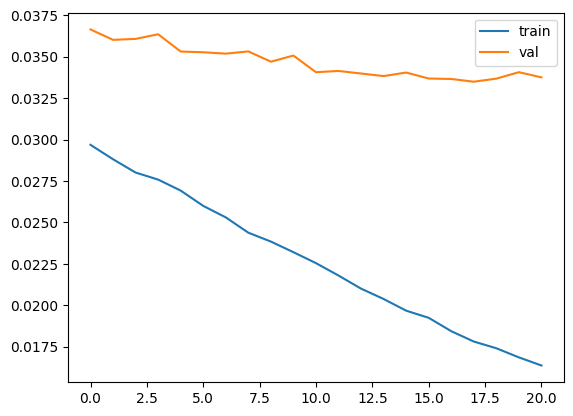

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

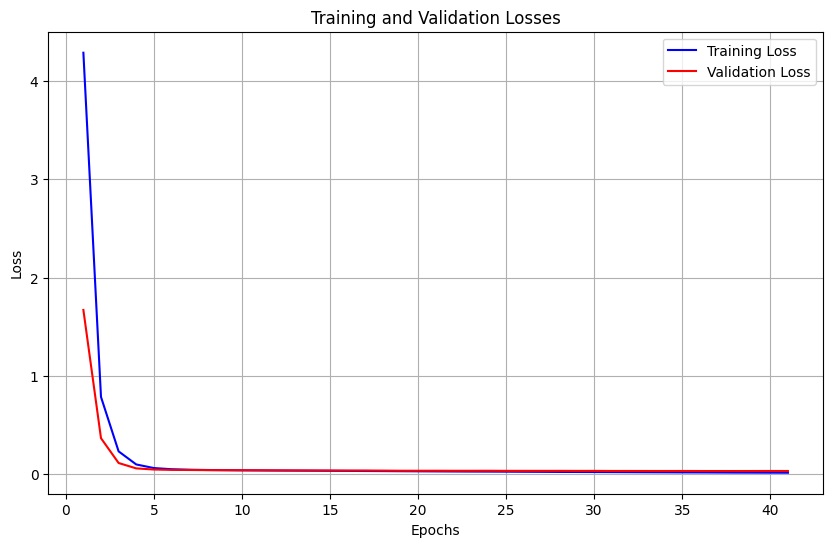

In [42]:
epochs = []
train_losses = []
val_losses = []

# Read the file and extract losses
with open(params_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        epochs.append(data['epoch'])
        train_losses.append(data['train_loss'])
        val_losses.append(data['val_loss'])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
loss = model.evaluate(
    [test_articles_seq, test_summaries_seq],
    tf.expand_dims(test_summaries_seq, axis=-1)
)

print("Test Loss:", loss)

360/360 [==============================] - 332s 921ms/step - loss: 0.0325
Test Loss: 0.03251456096768379


In [ ]:
latent_dim = 128

# Inference Encoder
encoder_model = Model(encoder_inputs,[encoder_outputs, state_h, state_c], name="prediction_encoder")
encoder_model.summary()

# New inputs for the encoder outputs and the input sequence
encoder_outputs_input = Input(shape=(article_max_len, latent_dim * 2))
encoder_inputs = Input(shape=(article_max_len,))

# Decoder inputs
decoder_hidden_state_input = Input(shape=(article_max_len, latent_dim * 2))
decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs = Input(shape=(1,))

# Decoder LSTM and dense layer
decoder_embedding2 = Embedding(input_dim=len(summary_vocabulary), output_dim=embedding_dim,trainable=True)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = LSTM(latent_dim * 2, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)(decoder_embedding2, initial_state=decoder_states_inputs)

# Attention mechanism
attention = tf.keras.layers.Attention(name = "attention")([decoder_outputs2, encoder_outputs_input])
context_vector = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs2, attention])

# Pointer network
pointer_logits = TimeDistributed(Dense(1, name = "pointer"))(context_vector)
pointer_probs = tf.keras.layers.Softmax(axis=-1)(pointer_logits)  # Convert logits to probabilities

# Output gate (generation scalar)
output_gate = Dense(1, activation='sigmoid', kernel_regularizer='l2')(context_vector)

# Vocabulary probabilities
vocab_logits = TimeDistributed(Dense(len(summary_vocabulary), name = "dense"))(decoder_outputs2)
vocab_probs = tf.keras.layers.Softmax(axis=-1)(vocab_logits)  # Convert logits to probabilities

# Calculate final output distribution
final_probs = output_gate * vocab_probs + 1.5 * (1 - output_gate) * pointer_probs

# Final decoder model
decoder_model = Model(
    [decoder_inputs, encoder_inputs, encoder_outputs_input] + decoder_states_inputs,
    [final_probs, state_h2, state_c2],
    name = "prediction_decoder"
)

In [ ]:
encoder_model.save('/content/drive/MyDrive/aroha/seq2seq_pg/encoder_model.h5')
decoder_model.save('/content/drive/MyDrive/aroha/seq2seq_pg/decoder_model.h5')